Epoch 1/10


2024-05-15 22:45:45.113589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-15 22:45:45.254765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


   7/4984 [..............................] - ETA: 46s - loss: 0.6881 - accuracy: 0.5312    

2024-05-15 22:45:45.401204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4984/4984 [==============================] - ETA: 0s - loss: 0.0974 - accuracy: 0.9666

2024-05-15 22:46:26.228526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-15 22:46:26.283159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4984/4984 [==============================] - 46s 9ms/step - loss: 0.0974 - accuracy: 0.9666 - val_loss: 0.0296 - val_accuracy: 0.9979
Epoch 2/10
4984/4984 [==============================] - 44s 9ms/step - loss: 0.0294 - accuracy: 0.9926 - val_loss: 0.0155 - val_accuracy: 0.9995
Epoch 3/10
4984/4984 [==============================] - 44s 9ms/step - loss: 0.0224 - accuracy: 0.9947 - val_loss: 0.0149 - val_accuracy: 0.9997
Epoch 4/10
4984/4984 [==============================] - 44s 9ms/step - loss: 0.0185 - accuracy: 0.9955 - val_loss: 0.0113 - val_accuracy: 0.9999
Epoch 5/10
4984/4984 [==============================] - 44s 9ms/step - loss: 0.0156 - accuracy: 0.9961 - val_loss: 0.0089 - val_accuracy: 1.0000
Epoch 6/10
4984/4984 [==============================] - 44s 9ms/step - loss: 0.0133 - accuracy: 0.9967 - val_loss: 0.0102 - val_accuracy: 1.0000
Epoch 7/10
4984/4984 [==============================] - 44s 9ms/step - loss: 0.0118 - accuracy: 0.9972 - val_loss: 0.0070 - val_accuracy: 1.0

2024-05-15 22:53:07.151796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-15 22:53:07.194362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2767/2767 [==============================] - 7s 2ms/step


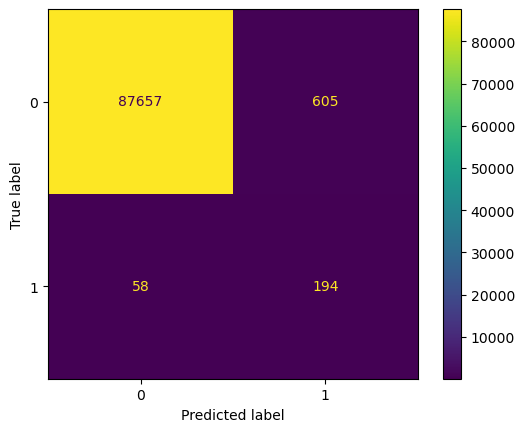

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load manually selected training and testing CSV files
train_files = ['Data/28_tracks_labeled.csv', 'Data/27_tracks_labeled.csv']  # Add your training files here
test_files = ['Data/26_tracks_labeled.csv']  # Add your testing files here

# Load and concatenate training data
train_data = pd.concat([pd.read_csv(file) for file in train_files], ignore_index=True)

# Load and concatenate testing data
test_data = pd.concat([pd.read_csv(file) for file in test_files], ignore_index=True)

# Sampling data (e.g., 10% of the original size)
train_data = train_data.sample(frac=0.1, random_state=42)
test_data = test_data.sample(frac=0.1, random_state=42)

# Assuming the datasets have been properly labeled and contain the 'stopped_before_pedestrian' column
features_cols = ['xCenter', 'yCenter', 'xVelocity', 'yVelocity', 'xAcceleration', 'yAcceleration', 'lonVelocity', 'latVelocity', 'lonAcceleration', 'latAcceleration']

# Split features and labels for training data
X_train = train_data[features_cols]
y_train = train_data['stopped_before_pedestrian']

# Split features and labels for testing data
X_test = test_data[features_cols]
y_test = test_data['stopped_before_pedestrian']

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Reshape data for LSTM: [samples, time_steps, features]
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Compute class weights for resampled data
class_weights_resampled = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weight_dict_resampled = dict(enumerate(class_weights_resampled))

# Build the LSTM model
model = Sequential([
    LSTM(50, input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2])),  # Increased number of units
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=64, validation_split=0.2, class_weight=class_weight_dict_resampled, callbacks=[early_stopping])

# Predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
